In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import re
import math
import time
import timeit

import sounddevice as sd
from scipy.io import wavfile
import IPython.display as ipd
import soundfile as sf

from multiprocess import Pool
import functools
import pdb

In [2]:
# import session_info
# session_info.show()

In [3]:
sd.query_devices()
# sd.default.device = 3

> 0 MacBook Air Microphone, Core Audio (1 in, 0 out)
< 1 MacBook Air Speakers, Core Audio (0 in, 2 out)

### Function to create file

In [4]:
def midi_to_timeseries(midiPath):
    """ Function that converts .txt file with midi events* to a list and returns all note on events.
    
    Args:
        midiPath: file path - .txt file with all note and pedal events of form [t,event,note/pedal,vel]
    
    Returns:
        time_notes: list of the form[[t,note,vel],[t,note,vel],[t,note,vel],...]
    
    """

    #    MIDI EVENT TYPES
    #    0x80 (hex)      128 (decimal)    Note Off
    #    0x90 (hex)      144 (decimal)    Note On
    #    0xB0 (hex)      176 (decimal)    Continuous Controller
    
    time_notes = []
    uniqueTypes = [128,144,176] 
            
    with open(midiPath) as midi_events:
        for line in midi_events:
            processedLine = line.split(" ")
    
            processedLine[0] = int(processedLine[0]) # processedLine[0] is timestamp
            processedLine[1] = int(processedLine[1], 16) # processedLine[1] is event type
            processedLine[2] = int(processedLine[2], 16) # processedLine[2] is note
            processedLine[3] = int(processedLine[3],16) # processedLine[3] is velocity

            if processedLine[1] not in uniqueTypes:
                print("unexpected event type got! ", processedLine[1])

            if processedLine[1] == 144:
                time_notes.append([processedLine[0], processedLine[2], processedLine[3]])
                
    return np.array(time_notes)

### Function to read .wav file

In [5]:
def read_audio(file):
    """ Function that reads .wav file of midi recording and saves it to a global variable
    Args:
        file: .txt file with midi notes
    """
    
    global samplerate, piano_audio
    samplerate, piano_audio = wavfile.read(file)

read_audio('Audio.wav')

/var/folders/f5/4s_l2s456y985n42_18zrt_00000gn/T/ipykernel_56114/2785934704.py:8: WavFileWarning: Chunk (non-data) not understood, skipping it.
  samplerate, piano_audio = wavfile.read(file)


### Functions to deal with notes as integers vs names

In [6]:
def int_to_note(i):
    """ Function that converts note from integer to name
    Args:
        i: integer value corresponding to note
    Returns:
        note: note name, eg. "C4" 
    """
    
    # convert integer to note
    notes = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    return notes[i%12] + str(i//12 - 1)

def note_to_int(note):
    """ Function that converts note from name to integer
    Args:
        note: note name, eg. "C4"
    Returns:
        i: integer value corresponding to note
    """
    
    # convert integer to note
    temp = re.compile("([a-zA-Z]+)([0-9]+)")
    note = temp.match(note).groups()
    notes = {'C':0,'C#/Db':1,'C#':1,'Db':1,'D':2,'D#/Eb':3,'D#':3,'Eb':3,'E':4,'F':5,'F#/Gb':6,'F#':6,'Gb':6,'G':7,'G#/Ab':8,'Ab':8,'G#':8,'A':9,'A#/Bb':10,'A#':10,'Bb':10,'B':11}
    return notes[note[0]] + 12*(int(note[1])+1)


### Functions to help judge quality of match

In [7]:
def predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, curr_time,pred_time=100,sound=False):
    """ Function that predicts the next 100 ms given a match
    Args:
        notes: 
        source_id_start: 
        source_id_end: 
        target_id_start: 
        target_id_end: 
        curr_time: 
        
    Returns:
        pred: predicted notes for 100ms, [[predTime1, note1, vel1], [predTime2, note2, vel2],...]
    """
    
    # predicting pred_time(100ms) of music
    time_ratio = (notes[target_id_start][0]-notes[target_id_end][0])/(notes[source_id_start][0]-notes[source_id_end][0])
    last_matching_note_target=0
    for event1 in range(source_id_start,source_id_end,-1):
        for event2 in range(target_id_start,target_id_end,-1):
            s = note_similarity(notes[event1],notes[event2],time_ratio)
            if s > 0:
                last_matching_note_target = event2
                break
        if last_matching_note_target:
            break
    
    target_time = notes[last_matching_note_target][0]
    time = target_time
    predicted = [target_id_start]
    i = target_id_start + 10
    while time <= target_time + pred_time:
        if notes[i][0] < time:
            predicted.append(i)
            i += 1
        time += 10
    predicted.append(i)
    
        
    if(sound):
        play_match(notes[source_id_start][0],notes[source_id_end][0],notes[predicted[-1]][0],notes[predicted[0]][0],pausebetween=False)
        
    return predicted

def predict1(notes, target_time, curr_time, target_id_start, pred_time=100,sound=False):
    """ Function that predicts the next 100 ms given a match
    Args:
        notes: 
        source_id_start: 
        source_id_end: 
        target_id_start: 
        target_id_end: 
        curr_time: 
        
    Returns:
        pred: predicted notes for 100ms, [[predTime1, note1, vel1], [predTime2, note2, vel2],...]
    """
    
    # predicting pred_time(100ms) of music
    time = target_time
    predicted = [target_id_start]
    i = target_id_start + 10
    while time <= target_time + pred_time:
        if notes[i][0] < time:
            predicted.append(i)
            i += 1
        time += 10
    predicted.append(i)
        
    if(sound):
        play_match(notes[source_id_start][0],notes[source_id_end][0],notes[predicted[-1]][0],notes[predicted[0]][0],pausebetween=False)
        
    return predicted
    
def display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, sourceStart, targetStart):
    """ Function that displays the snippets if they match.
    Args:
        notes: note name, eg. "C4"
        source_start: 
        source_end: 
        target_start: 
        target_end: 
        score: 
        sourceStart: 
        targetStart: 
    """
    
    print("Score: ", score)
    print("Source({st}):  Target({tt}): ".format(st=source_id_end, tt=target_id_end))
    for i in range(min(source_id_start-source_id_end, target_id_start-target_id_end)):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", ")
        print(notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
    for i in range(target_id_start-target_id_end, source_id_start-source_id_end):
        print(notes[i+source_id_end][0]-sourceStart, int_to_note(notes[i+source_id_end][1]), end=", \n")
    for i in range(source_id_start-source_id_end, target_id_start-target_id_end):
        print("        ,",notes[i+target_id_end][0]-targetStart, int_to_note(notes[i+target_id_end][1]))
        
    print("  Next notes: ")
    for i in range(5):
        print(notes[i+source_id_start][0]-sourceStart,int_to_note(notes[i+source_id_start][1]), end=", ")
        print(notes[i+target_id_start][0]-targetStart,int_to_note(notes[i+target_id_start][1]))
        
    print()
        
def play_match(source_start, source_end, target_start, target_end, pausebetween=False):
    """ Function that plays portion of audio file corresponding to each sequence of a match
    Args:
        source_start: 
        source_end: 
        target_start: 
        target_end: 
    """
    
    global piano_audio
    ss = (source_start * samplerate) // 1000
    se = (source_end * samplerate) // 1000
    te = (target_end * samplerate) // 1000
    ts = (target_start * samplerate) // 1000
    #Source
    sd.play(piano_audio[se:ss], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
    #Target
    sd.play(piano_audio[te:ts], samplerate, blocking = True)
    if pausebetween:
        time.sleep(1)
        
def display_snippet_plot(notes, source_start, source_end, target_start, target_end, score, sourceStart, targetStart):
    plt.figure(figsize = (10,5))
    lenSource = source_start-source_end
    lenTarget = target_start-target_end
    timeStampSourceEnd = notes[(lenSource - 1)+source_end][0]-sourceStart
    timeStampTargetEnd = notes[(lenTarget - 1)+target_end][0]-targetStart

    if timeStampSourceEnd >= timeStampTargetEnd:
        xmax = timeStampSourceEnd
    else:
        xmax = timeStampTargetEnd

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    title = "Snippet Plot:" + ", Source @ " + str(notes[source_end][0]) + " ms, Target @ " + str(notes[target_end][0]) + " ms, Score: " + str(round(score,4))
    plt.title(title)
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = []
    sourceY = []
    targetX = []
    targetY = []
    for i in range(min(source_start-source_end, target_start-target_end)):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))
    for i in range(target_start-target_end, source_start-source_end):
        sourceX.append(notes[i+source_end][0]-sourceStart)
        sourceY.append((notes[i+source_end][1]))
    for i in range(source_start-source_end, target_start-target_end):
        targetX.append(notes[i+target_end][0]-targetStart)
        targetY.append((notes[i+target_end][1]))

    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()

def display_snippet_plot_2(sequence1,sequence2,source_start,target_start,score=0,time_ratio=1):
    plt.figure(figsize = (10,5))

#     plt.xlim(0,xmax)
    plt.xlabel("Relative Snippet Time (in MS)")
    # yscale = ['C','C#/Db','D','D#/Eb','E','F','F#/Gb','G','G#/Ab','A','A#/Bb','B']
    # plt.yticks(range(0,len(yscale)),yscale)
    plt.ylabel("Note (Integer Representation)")
    plt.locator_params(axis="both", integer=True, tight=True)

    sourceX = [] # x axis - source timestamp in ms
    sourceY = [] # y axis - note integer repr for source
    targetX = []
    targetY = []
    for i in range(len(sequence1)):
        sourceX.append(sequence1[i][0]*time_ratio)
        sourceY.append(sequence1[i][1])

    for i in range(len(sequence2)):
        targetX.append(sequence2[i][0])
        targetY.append(sequence2[i][1])

    title = "Snippet Plot:" + ", Source @ " + str(source_start) + " ms, Target @ " + \
        str(target_start) + " ms, Score: " + str(score) + ", Length (ms): "+ str(sourceX[-1]-sourceX[0])
    plt.title(title)
    plt.scatter(sourceX, sourceY, label="Source",marker='*')
    plt.scatter(targetX, targetY, label="Target",marker='.')
    plt.legend()
    plt.show()
    
    
    

In [8]:
# Generates .wav file of predictions
def gen_prediction_wav(notes, df, thresh=0.7, pred_time=100):
    """ Function that ...
    
    Args:
        notes: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        df: Pandas DataFrame of source, match, and score information
                columns: ["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"]
        pred_time: number of ms outwards to predict
    
    Returns:
        pred_audio: Numpy array of WAV bits corresponding to predicted WAV file 
    
    """
    # Create blank Numpy WAV data
    global input_audio
    input_audio = np.mean(piano_audio,axis=1)
    input_audio /= np.max(input_audio)
    pred_audio = np.zeros(input_audio.shape)

    # Loop through matches
    arr = np.array(df)
    for i in range(arr.shape[0]):

        # Extract data per match
        sourceTimestamp = arr[i,0]
        targetTimestamp = arr[i,1]
        score = arr[i,2]
        sourceIDStart = int(arr[i,3])
        sourceIDEnd = int(arr[i,4])
        targetIDStart = int(arr[i,5])
        targetIDEnd = int(arr[i,6])

        # Get predicted notes
#         predicted = predict1(notes, targetTimestamp, sourceTimestamp, targetIDStart, pred_time=pred_time, sound=False)

        # Calculate indices to extract from piano_audio
        predEnd = int(targetTimestamp * samplerate) // 1000
        predStart = int((targetTimestamp + pred_time) * samplerate) // 1000

        # Calculate indices for placing data in pred_audio
        locStart = int(sourceTimestamp * samplerate) // 1000
        dist = predStart - predEnd
        locEnd = locStart + dist

        # Makes sure we don't overwrite existing match data
        nonZero = False
        if locEnd >= piano_audio.shape[0] or pred_audio[locStart:locEnd].any():
            nonZero = True
            print("Avoiding overwriting existing data!")
        
        # Only writes to pred_audio if score is above our 0.7 threshold
        if not nonZero and score > thresh:
            pred_audio[locStart:locEnd] = input_audio[predEnd:predStart]
            
    return pred_audio

### Functions to calculate similarity

In [9]:
def two_way_similarity(tf1, tf2, disp = False):
    a1,b1,score1 = musical_similarity(tf1,tf2,disp)
    b2,a2,score2 = musical_similarity(tf2,tf1,disp)
    if score1>score2:
        return a1,b1,score1
    return a2,b2,score2

def musical_similarity(tf1, tf2, disp = False):
    """ Function that calculates similarity score between 2 snippets 
        eg [[-17,60],[-100,62],[-101,64],[-300,60]] and [[-20,60],[-50,61],[-101,64],[-102,62],[-307,60]]
    
    Args:
        tf1: first snippet [[t,note],[t,note],[t,note],...]
        tf2: second snippet [[t,note],[t,note],[t,note],...]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    
    # TO dO: 
    # 1) trim unmatched ends of both snips before penalizing 0 scores
    # 2) penalize 0 scores more
    # 3) fix scaling
    
#     pdb.set_trace()
    
    tf1 = np.array(tf1)
    tf2 = np.array(tf2)
    
    # updating time stamps wrt first note for tf1
    sequence1 = tf1
    sequence1[:,0] = tf1[:,0]-tf1[-1,0]
    
    # updating time stamps wrt first note for tf2
    ind = np.argwhere(tf2[:,1] == tf1[-1,1])
    if ind.any():
        ind = ind[-1]
        lastmatch1 = tf1.shape[0]-1
        lastmatch2 = int(ind[0])
        if type(lastmatch1) != int or type(lastmatch2) != int:
            print(type(lastmatch1),type(lastmatch2))
        if (tf1[lastmatch1] != tf1[-1]).all():
            print("Error in lastmatch1:",lastmatch1)
    else:
        ind = -1
        lastmatch1 = None
        lastmatch2 = None
    sequence2 = tf2
    sequence2[:,0] = tf2[:,0]-tf2[ind,0]
    
    seq_1_time_del = tf1[-1,0] - tf1[0,0]
    seq_2_time_del = tf2[-1,0] - tf2[0,0]
    
    time_ratio = seq_2_time_del / seq_1_time_del
#     time_ratio = 1
    
    # Calculating score array by comparing every note from each sequence and taking the best match
    scores = note_similarity_vect2(sequence1,sequence2,time_ratio*(np.arange(sequence2.shape[0],0,-1)))
    score = scores.max(axis=0)
    score2 = scores.max(axis=1)
    if lastmatch1 == None:
        lastmatch1, = np.nonzero(score)
        if lastmatch1.any():
            lastmatch1 = lastmatch1[-1]
        else:
            lastmatch1 = -1
        lastmatch2, = np.nonzero(score2)
        if lastmatch2.any():
            lastmatch2 = lastmatch2[-1]
        else:
            lastmatch2 = -1
            
    
    
    # For every pair of notes in both sequences, if a match was not found, add a zero score
    count_zeros = np.sum(score==0)
#     count_score = score.shape[0] + count_zeros
    count_score = sequence1.shape[0] + sequence2.shape[0] + count_zeros - score.shape[0]
  
    # Similarity of the two sequences is the mean of the note similarity scores
    score_1 = np.sum(score)/(count_score)
    
    # including length in score, if at least 5 notes
    if len(tf1)>5:
        score_1 += score_1 * seq_1_time_del/500000 # 50 seconds yield 10% increase
    
    if disp:# and score_1>0.7:
        print("Scores:",score)
        print("Sequence1: ",sequence1)
        print("Sequence2: ",sequence2)
        print("Count zeros: ",count_zeros)
#         print("Matched vals: ",matched_targets)
        display_snippet_plot_2(sequence1,np.array(sequence2),tf1[0][0],tf2[0][0],score_1, 1)
    
#     return score_1

    return lastmatch1, lastmatch2, score_1

def note_similarity_vect2(sequence1,sequence2,ratio):
    """ Function that calculates similarity score between 2 notes - depending on note value and time
    
    Args:
        note1: first note to compare [t,note]
        note2: second note to compare [t,note]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # score is linear with time difference between notes
    
    min_dist = 50 * ratio[:,None] # acceptable time difference for same note
#     min_dist = 600 + np.minimum((10 * ratio[:,None]),200) # alternate
    
    time_diff = abs(sequence1[None,:,0] - sequence2[:,None,0]).astype(float)
    
    # remapping time diff to 0.5-1
    op = (sequence1[None,:,1] == sequence2[:,None,1]) * (time_diff < (min_dist)) * (1 - time_diff/min_dist)
    
    return op

def note_similarity_vect_scaling(sequence1,sequence2,ratio):
    """ Function that calculates similarity score between 2 notes - depending on note value and time
    
    Args:
        note1: first note to compare [t,note]
        note2: second note to compare [t,note]
    
    Returns:
        score: similarity - integer between 0 to 1
    
    """
    # score is linear with time difference between notes
    
    
    
    

### Helper Functions

In [10]:
def time_to_index(notes, timestamp):
    for i in range(len(notes)):
        if notes[i][0] >= timestamp:
            return i
        
def index_to_time(notes, index):
    return notes[index][0]

def index_to_sequence(notes, ids): # assume start>end & not include start for convention
    start_id, end_id = ids
    sequence = []
    for i in range(end_id,start_id):
        sequence.appaned(notes[i])
    return sequence

def time_to_sequence(notes, times): # assume start>end & not include start for convention
    start, end = times
    i = time_to_index(notes, end)
    sequence = []
    while i < len(notes):
        if notes[i][0]>=start:
            break
        sequence.append(notes[i])
        i += 1
    return sequence

def find_note(notes, time, note_val, max_time_dist = 10000):
    note_id = time_to_index(notes,time)
    op1 = None
    op2 = None
    
    end = time_to_index(notes,min(time+max_time_dist,notes[-1][0]))-1
    # checking forward
    for i in range(note_id,end):
        if notes[i][1] == note_val:
            if abs(notes[i][0]-time) > max_time_dist:
                print("UP",abs(notes[i][0]-time))
            op1 = i
            break
    
    end = time_to_index(notes,max(time-max_time_dist,0))
    # checking reverse
    for i in range(note_id-1,end,-1):
        if notes[i][1] == note_val:
            if abs(notes[i][0]-time) > max_time_dist:
                print("DOWN",abs(notes[i][0]-time),time,time-max_time_dist,note_id,end,i)
            op2 = i
            break
    
    if not op1:
        return op2
    if not op2:
        return op1
    if abs(notes[op1][0]-time) < abs(time-notes[op2][0]):
        return op1
    return op2


In [11]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

Scores: [-0.         -0.          0.94199696  0.92832576  0.97446605  0.90253709
  0.9470407   0.9448791   0.96158996  0.99243439  0.94841627  0.97049411
  0.97478129  0.98378797  0.95744342  0.57783876  0.76924878  0.82409948
  0.78816282  0.72763791  1.        ]
Sequence1:  [[-4814    55    45]
 [-4790    59    39]
 [-4184    71    55]
 [-4173    50    45]
 [-3578    55    51]
 [-3573    59    34]
 [-3030    55    48]
 [-3014    59    29]
 [-2804    62    49]
 [-2728    63    54]
 [-2644    65    59]
 [-2461    63    54]
 [-2444    51    53]
 [-1822    58    36]
 [-1820    55    44]
 [-1264    55    49]
 [-1250    58    44]
 [ -613    70    58]
 [ -602    51    46]
 [   -3    55    45]
 [    0    58    32]]
Sequence2:  [[-4233    50    42]
 [-4230    71    55]
 [-3646    59    37]
 [-3596    55    39]
 [-2995    55    46]
 [-2980    59    23]
 [-2782    62    43]
 [-2724    63    56]
 [-2619    65    45]
 [-2474    63    49]
 [-2434    51    53]
 [-1835    55    49]
 [-1827    58    

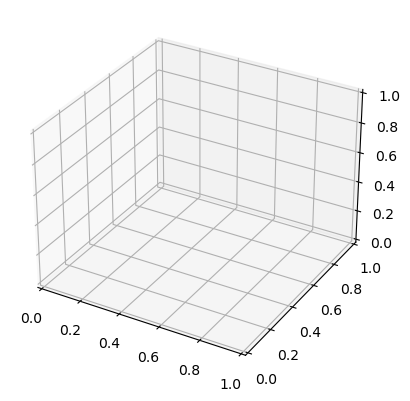

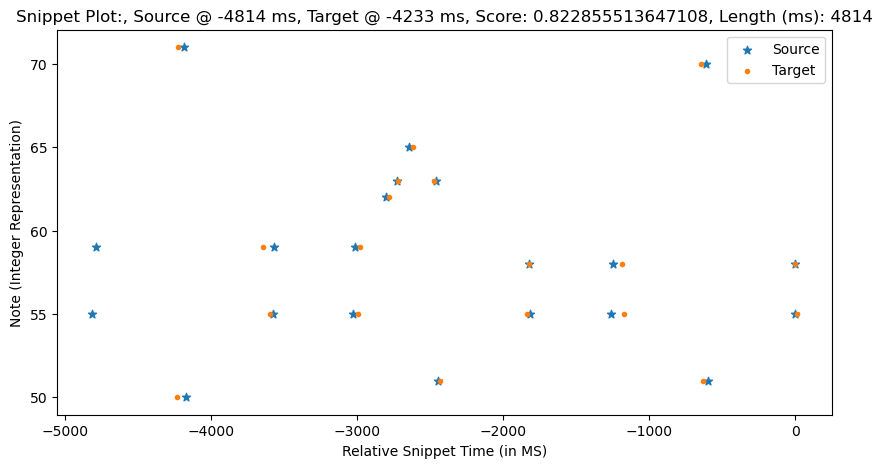

Scores: [0.92950561 0.94620165 0.90637464 0.96889953 0.97297715 0.97230577
 0.98644339 0.98825093 0.97917211 0.95594101 0.99608364 0.93202327
 0.96254985 0.82728874 0.76208143 0.81054632 0.7650187  0.78851683
 1.        ]
Sequence1:  [[-4242    50    42]
 [-4239    71    55]
 [-3655    59    37]
 [-3605    55    39]
 [-3004    55    46]
 [-2989    59    23]
 [-2791    62    43]
 [-2733    63    56]
 [-2628    65    45]
 [-2483    63    49]
 [-2443    51    53]
 [-1844    55    49]
 [-1836    58    34]
 [-1198    58    26]
 [-1180    55    35]
 [ -653    70    53]
 [ -639    51    51]
 [   -9    58    33]
 [    0    55    42]]
Sequence2:  [[-4811    55    45]
 [-4787    59    39]
 [-4181    71    55]
 [-4170    50    45]
 [-3575    55    51]
 [-3570    59    34]
 [-3027    55    48]
 [-3011    59    29]
 [-2801    62    49]
 [-2725    63    54]
 [-2641    65    59]
 [-2458    63    54]
 [-2441    51    53]
 [-1819    58    36]
 [-1817    55    44]
 [-1261    55    49]
 [-1247    58    4

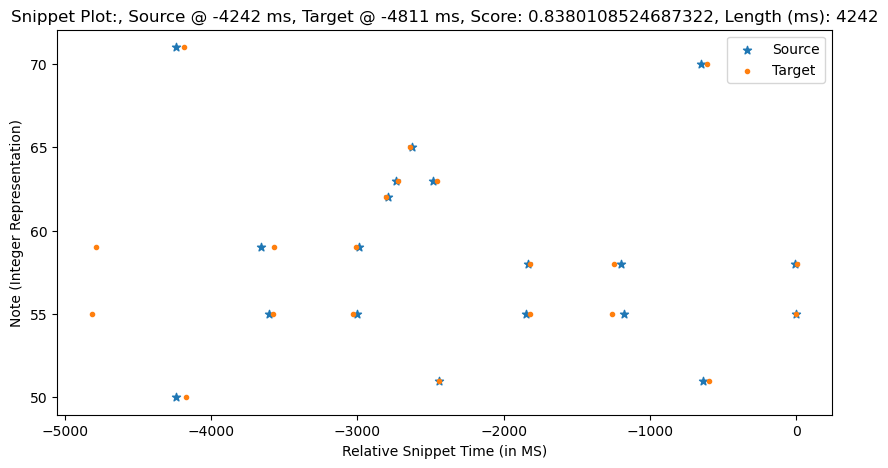

ValueError: not enough values to unpack (expected 5, got 3)

In [12]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

# matches=[]
for x in range(5000,10000,500):
#     print(x)
#     x = 0
    for y in range(5000,50000,2000):
        t1 = [y+x,0+x] # timestamps in ms
        t2 = [191400+y+x,191400+x]
#         t2 = [413000+y+x,413000+x]
#         t2 = [587000+y+x,587000+x]

        tf1 = time_to_sequence(notes, t1)
        tf2 = time_to_sequence(notes, t2)

#         a,b,c,d,score = musical_similarity(tf1,tf2,True)
        a,b,c,d,score = two_way_similarity(tf1,tf2,True)
        print(score)
#         matches.append([x,y,score])
        ax.scatter(x,y,score)
#         if score<0.8:
#             a,b,c,d,score = two_way_similarity(tf1,tf2,True)
#             display_snippet_plot(notes, time_to_index(notes,t1[0]),time_to_index(notes,t1[1]),time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), score, t1[0], t2[0])
    #         play_match(t1[0],t1[1],t2[0],t2[1])
    #         predict(notes, time_to_index(notes,t1[0]), time_to_index(notes,t1[1]), time_to_index(notes,t2[0]),time_to_index(notes,t2[1]), tf1[-1][0],pred_time=100,sound=True)
    #         time.sleep(2)
        break
    break

# plt.scatter3D(matches)
ax.set_xlabel('Start position (ms)')
ax.set_ylabel('Length of snip (ms)')
ax.set_zlabel('Score')
plt.show()

In [20]:
def calculate_similarity_time(notes, source_id, currTime, max_matches=None, skip = 100, disp=False):
    """ Function that calls musical similarity on targets generated for a source_id.
        Target snips start at every 100 ms, and has same time length as source.
    
    Args:
        notes: list of all notes from a recording [[t,note,vel],[t,note,vel],[t,note,vel],...]
        source_id: indices of note array corresponding to current time snippet (source_id_start>source_id_end) 
                   [source_id_start, source_id_end]
        currTime: time stamp at which we are searching for matches (ms)
        max_matches: optional param to state how many matches to stop after
        disp: boolean whether to print each match (defaults True)
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    calcstart = timeit.default_timer()
    matches = []
    last_id_end = 0 # track previous end index of target
    last_id_start = 0
    source_id_start, source_id_end = source_id
    source_end = notes[source_id_end][0] # start and end time stamps of source
    length_ms = currTime - source_end #in milliseconds
#     count = 0 # counting num "good" matches
    
    target_start = length_ms
    rewinded = False
    while target_start < currTime-5000:
#     for target_start in range(currTime-5000, currTime-1000, skip):
#         starttime = timeit.default_timer()
        target_end = target_start - length_ms # pick target_end by time length of course snip
        
        # finding new end index
        for i in range(last_id_end,len(notes)):
            if notes[i][0] >= target_end:
                target_id_end = i
                break
             
        # finding new start index
        for i in range(target_id_end,len(notes)):
            if notes[i][0] > target_start:
                target_id_start = i
                break
                
        if target_id_end > target_id_start-4:
            last_id_end = target_id_end
            last_id_start = target_id_start
            target_start += skip
            continue
        if target_id_end == last_id_end and last_id_start == target_id_start:
            target_start += skip
            continue
            
#         lm1,lm2,score = musical_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],disp=disp)
        lm1,lm2,score = two_way_similarity(notes[source_id_end:source_id_start], notes[target_id_end:target_id_start],disp=disp)
        
        if score:
            if score>0.7:
#                 count += 1
                # Dsiplaying matches > 0.7 if disp is True
                if disp:
                    display_match(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
#                     display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_end, notes[target_id_end][0])
                    play_match(currTime, source_end, target_start, target_end)
#                     predict(notes, source_id_start, source_id_end, target_id_start, target_id_end, currTime, target_start)
                    time.sleep(5)

            if score>0.5:
                target_time = target_start
#                 if rewinded:
#                     rewinded = False
                # case 1
                if lm1 >= source_id_start - source_id_end - 2:
                    target_time = notes[target_id_end+lm2][0] + (currTime - notes[source_id_end+lm1][0])
#                     target_time = notes[target_id_start-1][0] + mo2 - mo1
                    
#                     rewinded = True
#                     continue
#                     print(target_id_end+lm2,target_time)
                # case 2 - run again with target slightly ahead?
                elif lm2 >= target_id_start - target_id_end - 2:
                    if currTime - notes[source_id_end+lm1][0] < 0:
                        print("oops something went wrong with time calculations - might end in infinite loop")
                    target_start += currTime - notes[source_id_end+lm1][0]
                    continue
                # case 1 - lenient
#                 elif lm1 >= source_id_start - source_id_end - 3:
#                     target_time = notes[target_id_end+lm2][0] + (currTime - notes[source_id_end+lm1][0])
#                     rewinded = True
#                     continue
#                 # case 2 - lenient
#                 elif lm2 >= target_id_start - target_id_end - 3:
#                     if currTime - notes[source_id_end+lm1][0] < 0:
#                         print("oops something went wrong with time calculations - might end in infinite loop")
#                     target_start += currTime - notes[source_id_end+lm1][0]
#                     continue
                # random??
#                 else:
#                     target_time = notes[target_id_end+lm2][0] + (currTime - notes[source_id_end+lm1][0])
#                     rewinded = True
#                     continue
                    
                if target_time<currTime-5000:
                    matches.append([currTime, target_time, score, source_id_start, source_id_end, target_id_end+lm2, target_id_end])
        
        last_id_end = target_id_end
        last_id_start = target_id_start
        target_start += skip
        
#         if max_matches and count > max_matches:
#             break

#         looptime = timeit.default_timer() - starttime
#         if looptime>0.05:
#             print("LoopTime:",looptime,"target&source:",currTime,target_start)
        
    calctime = timeit.default_timer() - calcstart
    global t_exec
    t_exec[currTime]=calctime
#     if calctime>1:
#         print("Time:",calctime,"for source:",currTime,"and length",length_ms,"ms",",score:",matches[:][2])
    
    return matches


In [14]:
def get_source_notes(notes, start_time, min_notes, max_notes, min_time):
    """ Function that ...
    
    Args:
        snips: list of all note arrays of lengths min_notes to max_notes snip[1][2][3][4]
               1 - length of snip, 2 - start index from notes, 3 - index of note in array, 4 - [t, note, vel]
        start_time: start index of notes array - corresponding to current time
        min_notes: min number of notes for a valid sequence, integer
        max_notes: max note length for a snippet, integer
        min_time: min time length for a valid sequence, integer (ms)
        offset: used to find note snippets longer than min_length, integer, default=0
    
    Returns:
        matches: list of matches [[currTime, pastTime1, score1], [currTime, pastTime2, score2],...] 
    
    """
    start_index = np.argwhere(notes[:,0] > start_time)
    if start_index.any():
        start_index = start_index[0]
    else:
        print("Error: Start time too large")
        return np.array([None,None])
    
    if start_index<min_notes:
        return np.array([None,None])
    
    end_index = np.arange(start_index-min_notes, start_index - max_notes - 1, -1)
    ids = (start_time - notes[end_index,0] >= min_time) * end_index
    ids = ids[np.nonzero(ids)]
    if ids.any():
        source_id = np.array([start_index[0],ids[0]])
        return source_id
        
#     print("Error: Trying to access snippet length > max_notes",end=" ")
    return np.array([None,None])

In [15]:
def find_matches_at_timestamp(i, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp):
    """Function that finds similarity from lengths minNotes to maxNotes ...
    
    Args:
    
    Returns:
    
    """
    sims_arr = []
    print("\r",end="")
    print("i:",i,end="   ")
    # only calculate on historical timestamps
    offset = 500
#     count = notes[-1,0] + 1 # count number of relevant matches
    numSourceNotes = 0
    sourceTime = 0
#     attempt = 1
#     while numSourceNotes < maxNotes:
    while sourceTime < maxTime:
        sourceId = get_source_notes(notes, i, minNotes, maxNotes, sourceTime+offset)
        if not sourceId.any():
#             print("Failed for source_id = ", sourceId, ", on attempt ", attempt,end=" ")
#             if offset>0:
#                 percentage_matches_any += 1
            break

        # num notes in source snippet
        numSourceNotes = (sourceId[0] - sourceId[1])
        # total time in ms in source snippet
        sourceTime = i - notes[sourceId[1]][0]
        
        sim = calculate_similarity_time(notes, sourceId, i, disp=disp)
        for match in sim:
            match.append(numSourceNotes)
            match.append(sourceTime)
        sims_arr.extend(sim)
#         sim = np.array(sim)
#         count = np.sum(np.nonzero(sim[:,2] > thresh)[0])
        offset += 500
#         attempt += 1

#     print(sims_arr)
    return np.array(sims_arr)

In [21]:
midiPath = '../midi-recordings/ladispute.txt'
# midiPath = '../midi-recordings/2_prelude.txt'
notes = midi_to_timeseries(midiPath)

global t_exec

minNotes = 8
maxNotes = 200 # max length of snippet to be calculated
minTime = 1500 # min time in ms
maxTime = 30000 # if more matches, increase snippet length
thresh = 0.7
start = 191400
skip = 10
end = 365000
t_exec = np.zeros(notes[-1][0])

# calculating similarity
sims_arr = []
curr_times = np.arange(start, end, skip)
# fmt = np.vectorize(find_matches_at_timestamp,signature="(),"+str(notes.shape)+",(),(),(),(),(),()") #,signature="(2),(2),()->()", otypes=[np.float]
# sims_arr = fmt(curr_times, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False)

fm = functools.partial(find_matches_at_timestamp, notes=notes, minNotes=minNotes, minTime=minTime, maxNotes=maxNotes, maxTime=maxTime, thresh=thresh, disp=False)

# for i in curr_times:
#     sims_arr.extend(find_matches_at_timestamp(i, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))
# sarr = sims_a

# %prun sims_arr.extend(find_matches_at_timestamp(25000, notes, minNotes, minTime, maxNotes, maxTime, thresh, disp=False))



In [17]:
sd.play(piano_audio, samplerate)

In [18]:
sd.stop()

In [22]:
fm(25000)

with Pool(4) as p:
    sims_arr = p.map(fm, curr_times)

sarr = []
for i in range(len(sims_arr)):
    sarr.extend(sims_arr[i])

i: 25000   i:191400    202250    213100    223950    202260    191410    213110    202270    223960    191420    202280    191430    213120    223970    202290    191440    202300i: 213130    191450    223980    202310    213140    191460   

KeyboardInterrupt: 

In [ ]:
# Should score = score*(score>.5) + 0*(score<.5) ? (similiar to minmin - try that again)

# 1 was 200 + 10*ratio (good visual results but low percentage and some best matches are not "right")
# 1 is 50 * ratio (better results but matches get wider as we get longer matches)
# 2 is 500 + 10*ratio  (blah)
# curr was 600 + min(10*ratio,200), also penalty for 0 is divided by 2. NO GOOD
# curr was Should score = score*(score>.5) + 0*(score<.5) ? (similiar to minmin - try that again) NOT GREAT
# curr is above but with updated zero counting. BLAH
# curr was old zero counting, 50 * ratio and removing scores <0.5. BLAH
# curr was above minus removing <0.5 scores - should be same as 1 BLAH - that means somewthing else went wrong
# undid all changes (ratio from end, count zeros diff?) WORKED
# old is now w/ ratio from end GOOD, still blurry for long matches
# curr is with calc in calc_sim_time for lm1-2 - 1) keep 2 different if conditions BAAAAAD
# curr is 1 change above no goood infinite loop
# curr is for every 10ms (check histogram)


# simsDF_1 = simsDF_old
# simsDFall_1 = simsDFall_old
# simsDF_2 = simsDF_old
# simsDFall_2 = simsDFall_old
# simsDF_old = simsDF
# simsDFall_old = simsDFall

# possible errors:
# calc in calc_sim_time for lm1-2 - 2) see percentage each one is invoked
# lm1

In [ ]:
## choosing only significant scores and storing the new data in sims_plot

sarr = np.array(sarr)
sims_thresh = sarr * (sarr>thresh) # considering a match if score greater than a threshold

simsDF = pd.DataFrame(data=sims_thresh, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
simsDFall = pd.DataFrame(data=sarr, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])


In [ ]:
# plotting all mathes > threshold score

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True

title = "All matches >"+str(thresh)+", for \nMin Notes=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes)
simsDF.plot.scatter(x="source_timestamp", y="target_timestamp", s='score', title=title)


In [ ]:
# Plotting best match only

percentage_matches_any = 0
percentage_matches_thresh = 0
percentage_matches_line = 0
percentage_matches_thresh_line = 0
acc = 100 #ms accuracy for distance from line

plt.rcParams["figure.figsize"] = [7, 5]
plt.rcParams["figure.autolayout"] = True
bestMatches = []

toPlot = simsDFall
# toPlot = simsDFall_old

total = 0
distribution = np.arange(start,end,skip)
distribution_box = []
distribution_hist = []
close_matches = []
min_good_score = 1
for x in range(start,end,skip):
    y = toPlot.loc[toPlot['source_timestamp'] == x]['score']
    total += 1
    if y.any(): 
        y = y.idxmax()
        percentage_matches_any += 1
        if toPlot['score'].loc[y] > thresh:
            percentage_matches_thresh += 1
            if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
                percentage_matches_thresh_line += 1
        if np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))<acc:
            if toPlot['score'].loc[y] < min_good_score:
                min_good_score = toPlot['score'].loc[y]
            distribution_hist.append((toPlot['target_timestamp'].loc[y]-(x-191400)))
            percentage_matches_line += 1
            close_matches.append(toPlot.loc[y])
            close_matches[-1] += toPlot['target_timestamp'].loc[y]-(x-191400)
        distribution[(x-start)//skip] = np.abs(toPlot['target_timestamp'].loc[y]-(x-191400))
        distribution_box.append(np.abs(toPlot['target_timestamp'].loc[y]-(x-191400)))
    else:
#         print("No match for",x)
        distribution[(x-start)//skip] = -1
        continue
    bestMatch = [simsDFall['source_timestamp'].loc[y],simsDFall['target_timestamp'].loc[y],simsDFall['score'].loc[y],simsDFall['source_id_start'].loc[y],simsDFall['source_id_end'].loc[y],simsDFall['target_id_start'].loc[y],simsDFall['target_id_end'].loc[y]]
    bestMatches.append(bestMatch)
    plt.scatter(toPlot['source_timestamp'].loc[y],toPlot['target_timestamp'].loc[y],toPlot['score'].loc[y],c='blue')
bestMatches = np.array(bestMatches)
bestMatchesDF = pd.DataFrame(data=bestMatches, columns=["source_timestamp","target_timestamp", "score", "source_id_start", "source_id_end", "target_id_start", "target_id_end"])   

plt.plot(np.arange(170000,400000),np.arange(170000,400000))
plt.plot(np.arange(191400,391400),np.arange(200000))
percentage_matches_any /= total
percentage_matches_thresh /= total
percentage_matches_line /= total
percentage_matches_thresh_line /= total
print("Percentage matches found: {:.1f}%".format(percentage_matches_any*100))
print("Percentage matches >{:.1f} found: {:.1f}%".format(thresh,percentage_matches_thresh*100))
print("Percentage matches within {:d}ms of line: {:.1f}%".format(acc,percentage_matches_line*100))
print("Percentage matches >{:.1f} and within {:d}ms of the line: {:.1f}%".format(thresh,acc,percentage_matches_thresh_line*100))
print("Minimum score of a \"right match\": {:.2f}".format(min_good_score))

plt.title("Best match for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()


In [ ]:
# also plot histogram
mean = np.mean(distribution_hist)
std = np.std(distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(distribution_hist,bins=int(max(distribution_hist)))
plt.title("Histogram of time difference from expected")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Note distribution in first vs second playthrough

note_distribution_hist = []
for note in notes[time_to_index(notes,start):time_to_index(notes,end)]:
    # find closest note in history
    note2 = find_note(notes, note[0]-191400, note[1], max_time_dist = 100)
    if note2:
        note_distribution_hist.append(note[0]-notes[note2][0]-191400)
    
mean = np.mean(note_distribution_hist)
std = np.std(note_distribution_hist)
print("Distribution Mean:{:.2f}".format(mean))
print("Distribution Standad Deviation:{:.2f}".format(std))
plt.hist(note_distribution_hist,bins=int(max(note_distribution_hist)))
plt.title("Histogram of actual note deviation accross performances")
plt.xlabel("Time difference (ms)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
#['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time']
k = 1

# dtype = [('source_timestamp', float), ('target_timestamp', float), ('score', float),('source_id_start', float),\
#          ('source_id_end', float),('target_id_start', float),('target_id_end', float),('match_len', float),('match_time', float)]

close_matches_array = np.array(close_matches)
print(close_matches_array.shape)
close_matches_df = pd.DataFrame(data = close_matches_array, columns=['source_timestamp', 'target_timestamp','score','source_id_start','source_id_end','target_id_start','target_id_end','match_len','match_time'])
close_matches_df['deviation'] = np.abs(distribution_hist_array)

# close_matches_array[:,[2,1]] = close_matches_array[:,[1,2]]

# distribution_hist_array = np.array(distribution_hist)
# print(close_matches_array.shape)
# print(distribution_hist_array.shape)
# np.hstack((distribution_hist_array,close_matches_array))

# ind = np.argpartition(close_matches_array, k, axis=0, order=[])[:k,:]
# print(ind.shape)
# worst_matches = close_matches_array[ind,np.arange(close_matches_array.shape[1])[None,:]]

# close_matches_sorted = np.sort(close_matches_array,axis=0)

worst_matches = close_matches_df.sort_values(by=['deviation']).iloc[-k:]
worst_matches = np.array(worst_matches,dtype=int)

print(close_matches_df.iloc[0])
print(worst_matches.shape)
print(worst_matches)
for match in worst_matches:
    print(match)
    # plot worst match (in terms of distance from expected timestamp)
#     display_snippet_plot(notes, source_id_start, source_id_end, target_id_start, target_id_end, score, source_timestamp, target_timestamp)
#     display_snippet_plot(notes, int(match[3]), int(match[4]), int(match[5]), int(match[6]), match[2], int(match[0]), int(match[1]))
    sequence1 = np.copy(notes[int(match[4]):int(match[3])])
    sequence1[:,0] = sequence1[:,0]-191400
    sequence2 = np.copy(notes[int(match[6]):int(match[5])])
#     print(notes[1190:])
#     print(sequence1)
#     print(sequence2)
    display_snippet_plot_2(sequence1,sequence2,int(match[0]),int(match[1]))
    
#     two_way_similarity(sequence1, sequence2, disp = True)
    a = notes[int(match[3])-2:int(match[3])]
    b = notes[int(match[5])-1:int(match[5])+1]
    print(a)
    print(a[:,0] - 191400)
    print(b)
    print(a[1,0] - a[0,0])
    print(b[1,0] - b[0,0])
    
    
    


In [ ]:
# Plotting best match score 

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    else:
        if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
            color = 'orange'
        else:
            color = 'blue'
        plt.scatter(x,y,1,c=color) # need to include s (len of best match)

# count = 0
# scores = s.max(axis = 0)
# # if math.isnan(y):
# #     count += 1
# #     y = 0
# print(scores)
# plt.scatter(curr_times,scores) # need to include s (len of best match)
    

print(count)
plt.title("Best match score for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Best Match Score")
plt.show()

In [ ]:
# Plotting note length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_len'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color) # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in notes) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (#notes)")
plt.show()

In [ ]:
# Plotting time length of best match  

plt.rcParams["figure.figsize"] = [10, 3.50]
plt.rcParams["figure.autolayout"] = True

count = 0
for x in range(start,end,skip):
    y = simsDFall.loc[simsDFall['source_timestamp'] == x]['score'].max()
    s = simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y)]['match_time'].max()
#     print(s)
    if math.isnan(y):
        count += 1
        y = 0
    if (np.abs(simsDFall.loc[(simsDFall['source_timestamp'] == x) & (simsDFall['score'] == y) & (simsDFall['match_len'] == s)]['target_timestamp']-(x-191400))<100).any():
        color = 'orange'
    else:
        color = 'blue'
    plt.scatter(x,s,1,c=color) # need to include s (len of best match)
    
# print(count)
plt.title("Best match length (in time) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
# plt.colorbar()
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Match Length (ms)")
plt.show()

In [ ]:
plt.scatter(curr_times,t_exec[curr_times])
# plt.scatter(range(len(t_exec)),t_exec)
plt.title("Execution time (in seconds) for \nMin Snippet Length=" + str(minNotes) + " notes, Max Notes=" + str(maxNotes))
plt.xlabel("Source Timestamp (ms)")
plt.ylabel("Execution Time (s)")
plt.show()

In [ ]:
# Generate predictions
pred_audio = gen_prediction_wav(notes, bestMatchesDF, thresh=0.7, pred_time=skip)
pred_audio /= np.max(pred_audio)

# combine orig and pred audio in left and right
audio_to_save = np.vstack((pred_audio, input_audio)).T

In [ ]:
# Predicted audio
ipd.Audio(pred_audio,rate=samplerate)

In [ ]:
# Combined Audio - NOT RUNNING, just save file and listen on computer
ipd.Audio((audio_to_save),rate=samplerate)

In [ ]:
# # Saves predicted WAV data to file
# pred_fname = "pred.wav"
# wavfile.write(pred_fname, samplerate, audio_to_save)

---

To play stereo, I use Audacity to combine the two mono files for now manually. 

This can be done by loading in the two WAV files to Audacity and moving the L-R sliders such that one of the files only plays out of the left ear and the other plays out of the right. (The two files in this case would be mono.wav and whatever output prediction we get from the above function.

Also, make sure to reduce distortion of the prediction WAV by going to Effect > Volume and Compression > Normalize and set the peak to -1.0 DB.